In [2]:
from pathlib import Path
import sys
import os
import pandas as pd
sys.path.append("../..")
from neuralhydrology.datasetzoo import HourlyCamelsUSTO

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

In [3]:
data_dir = Path(r"F:\Data\LSH\CAMELS_US_TORONTO")


In [4]:
import torch
torch.cuda.is_available()

True

In [ ]:

start_run(config_file=Path("ar_camels_augmented.yml"))
#start_run(config_file=Path("mts_camels_augmented.yml"))

#start_run(config_file=Path("toronto_1h_small.yml"))
#start_run(config_file=Path("toronto_mts.yml"))
#start_run(config_file=Path("toronto_ar.yml"))

2025-07-08 08:57:13,041: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\08_Toronto\runs\test_mts_camels_ar_64_0807_085713\output.log initialized.
2025-07-08 08:57:13,042: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\08_Toronto\runs\test_mts_camels_ar_64_0807_085713
2025-07-08 08:57:13,043: ### Run configurations for test_mts_camels_ar_64
2025-07-08 08:57:13,043: experiment_name: test_mts_camels_ar_64
2025-07-08 08:57:13,044: train_basin_file: 128_basin_list.txt
2025-07-08 08:57:13,045: validation_basin_file: 128_basin_list.txt
2025-07-08 08:57:13,045: test_basin_file: 128_basin_list.txt
2025-07-08 08:57:13,046: train_start_date: 2008-01-01 00:00:00


2025-07-08 08:57:13,047: train_end_date: 2016-01-01 00:00:00
2025-07-08 08:57:13,048: validation_start_date: 2016-01-01 00:00:00
2025-07-08 08:57:13,049: validation_end_date: 2020-01-01 00:00:00
2025-07-08 08:57:13,050: test_start_date: 2020-01-01 00:00:00
2025-07-08 08:57:13,051: test_end_date: 2024-01-01 00:00:00
2025-07-08 08:57:13,051: device: cuda:0
2025-07-08 08:57:13,052: validate_every: 8
2025-07-08 08:57:13,052: validate_n_random_basins: 32
2025-07-08 08:57:13,053: metrics: ['NSE', 'KGE', 'PI']
2025-07-08 08:57:13,054: model: arlstm
2025-07-08 08:57:13,054: transfer_mtslstm_states: {'h': 'linear', 'c': 'linear'}
2025-07-08 08:57:13,055: head: regression
2025-07-08 08:57:13,055: output_activation: linear
2025-07-08 08:57:13,056: hidden_size: 64
2025-07-08 08:57:13,056: initial_forget_bias: 3
2025-07-08 08:57:13,057: allow_subsequent_nan_losses: 8
2025-07-08 08:57:13,058: output_dropout: 0.4
2025-07-08 08:57:13,058: optimizer: Adam
2025-07-08 08:57:13,060: loss: NSE
2025-07-08 0

Every experiment in NeuralHydrology uses a configuration file that specifies its setup. The config file for this example is called `1_basin.yml` and can be found in the same directory as this notebook file.
Let's look at some of the relevant configuration options:

In [ ]:
from neuralhydrology.datasetzoo import camusto
import pandas as pd
ATTRIBUTE_FILES = ["hydromet.csv", "landuse.csv"]
data_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean")

attribute_files = ["hydromet.csv", "landuse.csv"]
for f in attribute_files:

    if f not in ATTRIBUTE_FILES:
        raise ValueError(f"attribute file '{f}' not available; choices include{ATTRIBUTE_FILES}")
dfs= [pd.read_csv(data_dir / f, index_col=0) for f in attribute_files]
for df in dfs:
    df.index.name = "TRCAID"

df = pd.concat(dfs, axis=1)

df = df.loc[~df.isnull().any(axis=1),:] # remove basins with missing values
df = df.loc[:,~(df.std() < 1E-10)] # remove attributes with std of 0


In [ ]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir {data_dir}

Launching TensorBoard...

In [1]:
run_config = Config(Path("mts_camels_augmented.yml"))
run_dir = Path("runs/test_mts_camels_augmented_64_2606_092458")  # you'll find this path in the output of the training above.

# create a tester instance and start evaluation

results = {}
for period in ["train","test"]:
    tester = get_tester(cfg=Config(run_dir / "config.yml"), run_dir=run_dir, period=period, init_model=True)
    results[period] = tester.evaluate(save_results=True, metrics=run_config.metrics)
    results[period].keys()

NameError: name 'Config' is not defined

Let's take a closer look at the predictions and do some plots, starting with the daily results.
Note that units are mm/h even for daily values, since we predict daily averages.

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\04-Multi-Timescale\../..\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\everett\Documents\GitHub\neuralhydrology\examples\04-Multi-Timescale\../..\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


ValueError: 'datetime' not found in array dimensions ('date',)

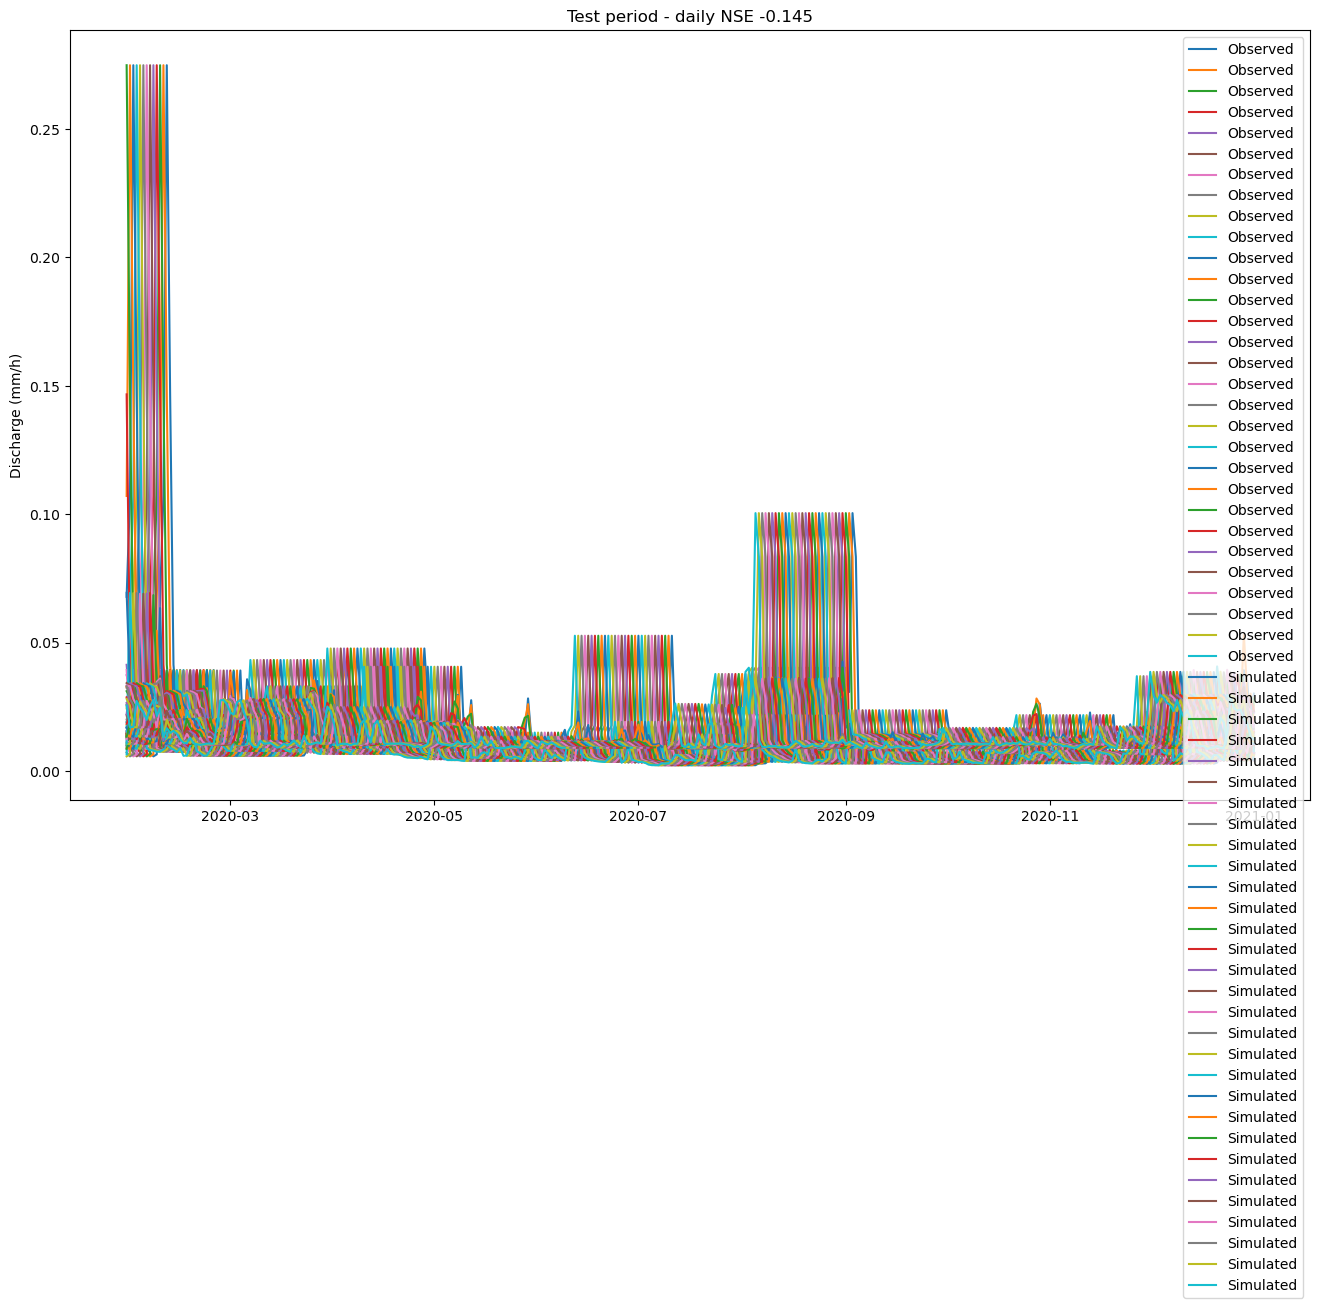

In [ ]:
# extract observations and simulations
daily_qobs = results["HY018"]["1d"]["xr"]["discharge(mm)_camusto_1h_obs"]
daily_qsim = results["HY018"]["1d"]["xr"]["discharge(mm)_camusto_1h_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
ax.legend()
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - daily NSE {results['HY018']['1h']['NSE_1h']:.3f}")

# Calculate some metrics
values = metrics.calculate_all_metrics(daily_qobs.isel(time_step=-1), daily_qsim.isel(time_step=-1), datetime_coord="date")
print("Daily metrics:")
for key, val in values.items():
    print(f"  {key}: {val:.3f}")

...and finally, let's look more closely at the last few months' hourly predictions:

In [ ]:
# extract a date slice of observations and simulations
hourly_xr = results["HY010"]["15min"]["xr"].sel(date=slice(None, None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select all 24 hours of each day and then stack
# the two dimensions into one consecutive datetime dimension.
hourly_xr = hourly_xr.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])

hourly_xr = hourly_xr.assign_coords(datetime=hourly_xr.coords['date'] + hourly_xr.coords['time_step'])

c:\Users\everett\.conda\envs\neuralhydrology\lib\site-packages\xarray\core\common.py:615: FutureWarning: Updating MultiIndexed coordinate 'datetime' would corrupt indices for other variables: ['date', 'time_step']. This will raise an error in the future. Use `.drop_vars({'datetime', 'date', 'time_step'})` before assigning new coordinate values.
  data.coords.update(results)


In [ ]:
hourly_xr["date"].values

array(['2017-01-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', ...,
       '2022-01-01T23:00:00.000000000', '2022-01-01T23:00:00.000000000',
       '2022-01-01T23:00:00.000000000'], dtype='datetime64[ns]')

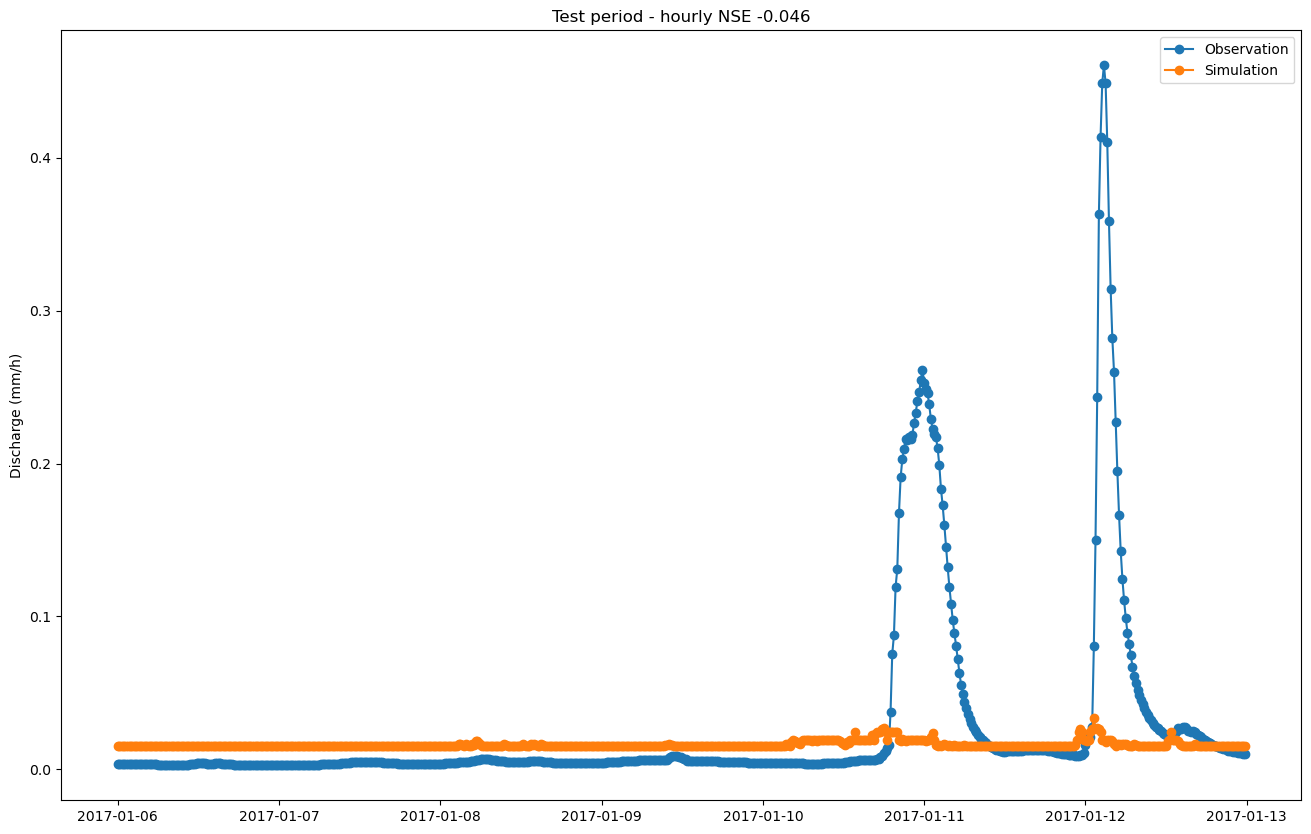

In [ ]:
import numpy as np
# extract a date slice of observations and simulations
hourly_xr = results["HY062"]["15min"]["xr"].sel(date=slice("01-06-2017", "01-12-2017"))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select all 24 hours of each day and then stack
# the two dimensions into one consecutive datetime dimension.
hourly_xr = hourly_xr.isel(time_step=slice(-4, None)).stack(datetime=['date', 'time_step'])
hourly_xr = hourly_xr.assign_coords(datetime=hourly_xr.coords['date'] + [np.timedelta64(ts*15,"m") for ts in hourly_xr.coords['time_step'].values])

hourly_qobs = hourly_xr["discharge(mm)_trca_15min_obs"]
hourly_qsim = hourly_xr["discharge(mm)_trca_15min_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_qobs["datetime"], hourly_qobs, 'o-', label="Observation")
ax.plot(hourly_qsim["datetime"], hourly_qsim, 'o-', label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['HY062']['15min']['NSE_15min']:.3f}")
_ = ax.legend()
